In [31]:
import numpy as np
import pandas as pd 

In [57]:
from typing import List
import csv

def parse_species_list(species_file: str, delimiter='\n') -> List[str]:
    with open(species_file, 'r') as f:
         species_list = [name for lst in csv.reader(f, delimiter=delimiter) 
                         for name in lst]          
    
    return species_list

In [71]:
# Article input
full_data = "./tests/data/4347_final_relative_abundances.txt"
MH_species_file = "./tests/data/MH_species.txt"
MN_species_file = "./tests/data/MN_species.txt"

# QIIME2-adapted input
q2_data = "./tests/data/relative_table.qza"
q2_h_species = "./tests/data/MH_species.tsv"
q2_n_species = "./tests/data/MN_species.tsv"

# OUTPUT
output_file = "GMHI_output.csv"

# TEST DATA


## Overall Steps
1. Run MetaPhlAn2 on a stool metagenome using '--tax_lev s' argument.
2. Merge outputs using 'merge_metaphlan_tables.py' script provided in the MetaPhlAn2 pipeline (see MetaPhlAn2's online tutorial).
3. Make sure of the following: The merged species' relative abundance profile should be arranged as shown in 'species_relative_abundances.csv'. Accordingly, the first column should contain names of the species-level clades (i.e., taxonomic names with 's__' flag). Subsequent columns should contain the species' relative abundances corresponding to each metagenome sample.
4. Save input data from Step-3 as a '.csv' file, and run the following script to calculate GMHI for each stool metagenome. GMHI values for each sample in 'species_relative_abundances.csv' are shown in 'GMHI_output.csv'.

## Importing relative abundances

### As in original paper

In [72]:
tmp = pd.read_csv(full_data, sep = "\t",
                   header = 0, index_col = 0)

### As Q2 Artifact API

In [73]:
from qiime2 import Artifact

tmp1 = Artifact.load(q2_data).view(pd.DataFrame).T

### Test: comparing 2 ways of data importing

In [74]:
# TEST: are inputs identical
tmp.round(13).equals(tmp1.round(13))

True

Proposed way of importing relative abundances through QIIME2 framework yields identical results.

## Further data processing

In [75]:
# Removing unclassified and virus species - skipped transposing steps
na_species = tmp1.index.str.contains('unclassified|virus', regex=True)
species_profile_2 = tmp1[~na_species]

In [76]:
# Re-normalization of species' relative abundances after removing unclassified and virus species
species_profile_3 = species_profile_2.apply(lambda x: x/x.sum(), axis=0)
species_profile_3[species_profile_3 < 0.00001] = 0

### Species list import

In [77]:
MH_species = parse_species_list(MH_species_file) # Health-prevalent species (7 in total)
MN_species = parse_species_list(MN_species_file) # Health-scarce species (43 in total)

### QIIME2 species list importing 

In [78]:
h_species = Artifact.import_data('FeatureData[Taxonomy]', q2_h_species, view_type='HeaderlessTSVTaxonomyFormat')
n_species = Artifact.import_data('FeatureData[Taxonomy]', q2_n_species, view_type='HeaderlessTSVTaxonomyFormat')

In [79]:
from q2_types.feature_data import (FeatureData, Taxonomy)
from typing import List

def species_list_from_q2_artifact(feature_data_taxonomy: FeatureData[Taxonomy]) -> List[str]:
    df = feature_data_taxonomy.view(pd.DataFrame)
    species_list = [x for x in df['Taxon']]
    
    return species_list

In [80]:
mh_list = species_list_from_q2_artifact(h_species)
mn_list = species_list_from_q2_artifact(n_species)

### Test: comparing features lists

In [81]:
mh_list == MH_species and mn_list == MN_species

True

## GMHI Calculation

In [82]:
# Extracting Health-prevalent species present in metagenome
MH_species_metagenome = species_profile_3[species_profile_3.index.isin(MH_species)]
# Extracting Health-scarce species present in metagenome
MN_species_metagenome = species_profile_3[species_profile_3.index.isin(MN_species)]

In [83]:
# Shannon index - alpha diversity
MH_not_zero = MH_species_metagenome[MH_species_metagenome > 0]
MN_not_zero = MN_species_metagenome[MN_species_metagenome > 0]
alpha = lambda x: -1 * np.sum(np.log(x) * x)
MH_shannon = MH_not_zero.apply(alpha, axis=0)
MN_shannon = MN_not_zero.apply(alpha, axis=0)

In [84]:
# Richness of Health-prevalent species
R_MH = MH_not_zero.count()
# Richness of Health-scarce species
R_MN = MN_not_zero.count()

In [85]:
constant = R_MH.rename('h').to_frame().join(R_MN.rename('n').to_frame())

### Rank ordering and primes calculation - see [Methods](https://www.nature.com/articles/s41467-020-18476-8#Sec15)

In [86]:
import re
# searching for healthy samples in dataset 
healthy_mask = tmp1.columns.str.contains('healthy', flags=re.I, regex=True)

# calculating healthy and non-healthy samples
n_healthy = healthy_mask.sum()
n_non_healthy = len(tmp1.columns) - n_healthy

# calculating kh and kn
n = 1 # kh and kn are 1% of all healthy and non-healthy samples respectively
kh = int(n_healthy*(n/100))
kn = int(n_non_healthy*(n/100))

#Median RMH from 1% of the top-ranked samples (see Methods)
HC1 = constant.sort_values(by=['h', 'n'], ascending=[False, True])
MH_prime = np.median(HC1[:kh]['h'])

#Median RMN from 1% of the bottom-ranked samples (see Methods)
NHC1 = constant.sort_values(by=['h', 'n'], ascending=[True, False])
MN_prime = np.median(NHC1[:kn]['n'])

### Creating GMHI table as output

In [87]:
# Collective abundance of Health-prevalent species
# Collective abundance of Health-scarce species

psi_MH = (R_MH / MH_prime) * MH_shannon 
psi_MN = (R_MN / MN_prime) * MN_shannon
index = np.log10((psi_MH + 0.00001) / (psi_MN + 0.00001))  # 0.00001 added to avoid having the denominator as 0

In [88]:
GMHI = pd.DataFrame(index, columns=['GMHI'])

## Plotting and visual inspection - [Fig. 3a](https://www.nature.com/articles/s41467-020-18476-8/figures/3)

In [89]:
GMHI['Type'] = GMHI.index.str.split("_", expand=True)
GMHI['Type'] = GMHI.Type.apply(lambda x: x[0])

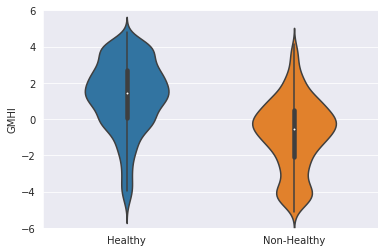

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt

GMHI['non-healthy'] = GMHI.Type != 'Healthy'

sns.set_style('darkgrid')
g = sns.violinplot(x='non-healthy', y='GMHI', data=GMHI, scale='width', width=0.5)
g.set(ylim=(-6, 6), xlabel='', xticklabels=['Healthy', 'Non-Healthy']);

In [91]:
GMHI.describe()

,GMHI
count,4347.000000
mean,0.435311
std,2.226649
min,-5.128125
25%,-0.864572
50%,0.586145
75%,2.063562
max,4.815488
